# Fig06a_Microphysics
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 23.12.2019
    Date last modified: 23.12.2019

    ##############################################################
    Purpos:

    1) Calculate dx dependencies of microphysics mixing ratios

    2) This program reads in preprocessed data from
    
    ~/papers/Idealized-MCSs/programs/Microphysics/Microphysics.py

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
# import shapely.geometry
# import descartes
import shapefile
import math
from scipy.stats.kde import gaussian_kde
from math import radians, cos, sin, asin, sqrt
from scipy import spatial
import matplotlib.path as mplPath
from pylab import *
from scipy.optimize import curve_fit
import scipy
import math
import SkewT
from scipy.interpolate import interp1d
from thermodynamics import Theta
# from astropy.io import ascii

### Load the microphisics statistics

In [111]:
################################################################################
################################################################################
#                            Settings

rgrGridSpacing=['12000','12000nc','4000','2000','1000','500','250']
rgrDX=[12000,12000,4000,2000,1000,500,250]
sSimDir='/glade/p/mmm/c3we/Idealized_MCSs/data/WRF/'
sGrid='12km'  # can be 'native' for native grid or '12km' for 12 km model grid
sDataDir='/glade/scratch/prein/Papers/Idealized_MCSs/data/Mikrophysics/'+sGrid+'/'

rgsSimulations=['19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5']#,

#                 '64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
#                 '41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '16_2002-06-11_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '34_2010-07-12_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '51_2003-06-23_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '56_2008-06-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
#                 '35_2004-07-02_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5']

iEvents=10 # number of events that will be considered

sPlotDir='/glade/u/home/prein/papers/Idealized-MCSs/plots/Fig06a_Microphysics/'

rgiDomSize=[51,51,155,311,623,1247,2495]
iOutInt=12 # slizes per hour
ihours=7 # runtime in hours
iSkipH=3 # hours that should be excluded from the simulation
iRadPmax=60000. # m
iRadVol=100000. # m for the volume calculation

Levels=16 # number of model levels that should be read in
rgrDXnative=250

height_z = np.linspace(125,24000,95); height_z=height_z/1000.
Smooth=12000 # smoothing filter lenth in m

iEvents=10 # number of events that will be considered

rgiDomSize=[51,51,155,311,623,1247,2495]
ihours=7 # runtime in hours

Microphysics=np.zeros((85,5,len(height_z),len(rgsSimulations),len(rgrGridSpacing))); Microphysics[:]=np.nan

for si in range(len(rgsSimulations)):
    print '    Load '+rgsSimulations[si]
    grDATA={}
    for dx in range(len(rgrGridSpacing)):
        try:
            fname=sDataDir+rgsSimulations[si]+'_'+rgrGridSpacing[dx]+'m_MP.pkl'
            dbfile = open(fname, 'rb')
            DATA=pickle.load(dbfile)
            Microphysics[:,:,:,si,dx]=DATA['MR']
            Variables=DATA['Variables']
        except:
            continue

MP_Mean=np.nanmean(Microphysics[12:,:,:,:,:], axis=(0,3))

# Test for significant differences
SIGNIFICANCE=np.zeros((Microphysics.shape[1],Microphysics.shape[2],Microphysics.shape[4])); SIGNIFICANCE[:]=np.nan
for hm in range(Microphysics.shape[1]):
    for hh in range(Microphysics.shape[2]):
        for dx in range(Microphysics.shape[4]):
            REF=np.nanmean(Microphysics[:,hm,hh,:,-1], axis=0); REF=REF[~np.isnan(REF)]
            PERT=np.nanmean(Microphysics[:,hm,hh,:,dx], axis=0); PERT=PERT[~np.isnan(PERT)]
            Min=np.min([len(REF),len(PERT)])
            SIGNIFICANCE[hm,hh,dx]=scipy.stats.wilcoxon(REF[:Min],PERT[:Min])[1]
# SIGNIFICANCE[MP_Mean*1000 < 0.001] = 1

    Load 19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5


/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: Mean of empty slice
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice


### Start Plotting

        Plot map to: /glade/u/home/prein/papers/Idealized-MCSs/plots/Fig06a_Microphysics/Fig06a_Microphysics.pdf


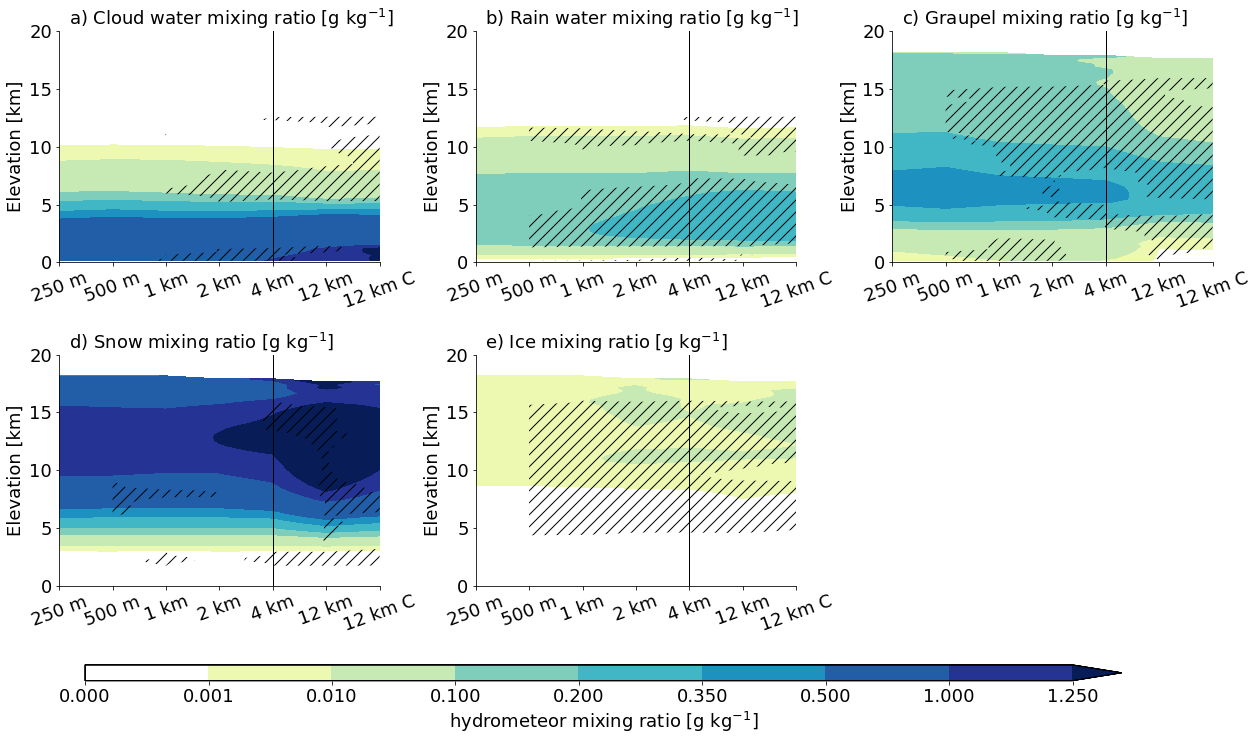

In [112]:
# set the font size
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(18,11))
plt.rcParams.update({'font.size': 18})

gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.08, right=0.97,
           bottom=0.20, top=0.9,
           wspace=0.3, hspace=0.4)

rgsColors=['k','#e31a1c']
SortedVars=['QCLOUD', 'QRAIN', 'QGRAUP','QSNOW', 'QICE']
XX=[0,1,2,0,1]
YY=[0,0,0,1,1]
for tp in range(len(SortedVars)):
    if SortedVars[tp] == 'QCLOUD':
        Label='Cloud water mixing ratio [g kg$^{-1}$]'
        DATA=MP_Mean[Variables.index('QCLOUD'),:,:]*1000.
        SIGN=SIGNIFICANCE[Variables.index('QCLOUD'),:,:]
    if SortedVars[tp] == 'QRAIN':
        Label='Rain water mixing ratio [g kg$^{-1}$]'
        DATA=MP_Mean[Variables.index('QRAIN'),:,:]*1000.
        SIGN=SIGNIFICANCE[Variables.index('QRAIN'),:,:]
    if SortedVars[tp] == 'QSNOW':
        Label='Snow mixing ratio [g kg$^{-1}$]'
        DATA=MP_Mean[Variables.index('QSNOW'),:,:]*1000.
        SIGN=SIGNIFICANCE[Variables.index('QSNOW'),:,:]
    if SortedVars[tp] == 'QICE':
        Label='Ice mixing ratio [g kg$^{-1}$]'
        DATA=MP_Mean[Variables.index('QICE'),:,:]*1000.
        SIGN=SIGNIFICANCE[Variables.index('QICE'),:,:]
    if SortedVars[tp] == 'QGRAUP':
        Label='Graupel mixing ratio [g kg$^{-1}$]'
        DATA=MP_Mean[Variables.index('QGRAUP'),:,:]*1000.
        SIGN=SIGNIFICANCE[Variables.index('QGRAUP'),:,:]
        
#     DATA[:,:][DATA[:,:] < 0.001]=np.nan

    ax = plt.subplot(gs1[YY[tp],XX[tp]])

    PlotData=DATA # ((DATA-DATA[:,-1][:,None])/DATA[:,-1][:,None])*100.
    Levels=np.array([ 0, 0.001,   0.01,  0.1,  0.2,  0.35, 0.5, 1, 1.25]) # np.linspace(-33,33,12)
    Colors=['#ffffff','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58']
    cs=plt.contourf(range(7)[::-1], height_z, PlotData, levels=Levels, extend='max', colors=Colors)
    csH=plt.contourf(range(7)[::-1], height_z, SIGN, 
                     levels=[0,0.05,1],hatches=['//',None], facecolor="none", fill=False, colors='none')

    xx = range(7)
    labels = [ '12 km C',  '12 km',  '4 km', '2 km','1 km','500 m', '250 m']
    plt.xticks(xx, labels[::-1], rotation=20)
    ax.set_ylabel('Elevation [km]')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(0, 6)
    plt.axhline(y=0, c='k', lw=0.5)
    plt.ylim(0,20)
    ax.axvline(x=4, ls='-', c='k', zorder=10, alpha=1, lw=1)

    ax.text(0.03,1.00, rgsLableABC[tp]+') '+Label, ha='left',va='bottom', \
            transform = ax.transAxes, fontname="Times New Roman Bold") #, fontsize=17)
    # add colorbar
    CbarAx = axes([0.10,0.08, 0.8, 0.02])
    cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', label='hydrometeor mixing ratio [g kg$^{-1}$]', ticks=Levels)

# Plot the figure
sPlotFile=sPlotDir
sPlotName= 'Fig06a_Microphysics.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print '        Plot map to: '+sPlotFile+sPlotName
fig.savefig(sPlotFile+sPlotName)

In [107]:
50*12*12

7200